<a href="https://colab.research.google.com/github/UTakeuchi/PDsimulator/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Q学習エージェント

In [2]:
def greedy_probs(Q, state, epsilon=0, action_size=2):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

In [3]:
class Agent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 2
        self.income = 0 #所得
        #self.rep = 'g' #評判(good or bad)    

        random_actions = {0: 0.5, 1: 0.5}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
    
    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def inc_update(self, reward):
        self.income += reward #income update

    def update(self, state, action, reward, next_state):
        next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
        next_q_max = max(next_qs)
        
        target = reward + self.gamma * next_q_max
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])

        self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

# Prisoner's dillema game

In [4]:
class PDGame:
    def __init__(self):
        self.action_space = [0, 1]
        self.action_meaning = {
            0: "Defect",
            1: "Cooperate",
        }
        self.b = 5 #benefit
        self.c = 1 #cost
    
    def matching(self, agents):
        pairs = len(agents) // 2
        return np.random.choice(agents, size=(pairs, 2), replace=False)
        
    def reward(self, a1, a2):
        u1 = {(1, 1):self.b - self.c, (1, 0):-self.c, (0, 1):self.b, (0, 0):0}
        u2 = {(1, 1):self.b - self.c, (1, 0):self.b, (0, 1):-self.c, (0, 0):0}
        return u1[(a1,a2)], u2[(a1,a2)]

# シミュレーションの実行

----------agent1's policy-----------
state:(0, 0), policy:{0: 0.0, 1: 1.0}
state:(4, -1), policy:{0: 1.0, 1: 0.0}
state:(9, -1), policy:{0: 1.0, 1: 0.0}
state:(8, 9), policy:{0: 0.0, 1: 1.0}
state:(12, 8), policy:{0: 1.0, 1: 0.0}
state:(17, 13), policy:{0: 1.0, 1: 0.0}
state:(22, 12), policy:{0: 1.0, 1: 0.0}
state:(21, 15), policy:{0: 1.0, 1: 0.0}
state:(26, 23), policy:{0: 1.0, 1: 0.0}
state:(31, 25), policy:{0: 1.0, 1: 0.0}
state:(31, 9), policy:{0: 1.0, 1: 0.0}
state:(31, 24), policy:{0: 1.0, 1: 0.0}
state:(30, 36), policy:{0: 1.0, 1: 0.0}
state:(35, 34), policy:{0: 1.0, 1: 0.0}
state:(34, 21), policy:{0: 1.0, 1: 0.0}
state:(39, 8), policy:{0: 1.0, 1: 0.0}
state:(38, 45), policy:{0: 0.0, 1: 1.0}
state:(42, 43), policy:{0: 1.0, 1: 0.0}
state:(47, 35), policy:{0: 1.0, 1: 0.0}
state:(52, 20), policy:{0: 1.0, 1: 0.0}
state:(57, 33), policy:{0: 1.0, 1: 0.0}
state:(62, 17), policy:{0: 1.0, 1: 0.0}
state:(62, 55), policy:{0: 1.0, 1: 0.0}
state:(61, 51), policy:{0: 1.0, 1: 0.0}
state:(61, 7

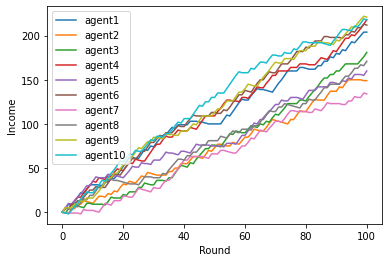

In [22]:
env = PDGame()
n = 10 # agentの人数 n
agents = []
income_history = []
for i in range(n):
    agents.append(Agent())
    income_history.append([0])

rounds = 100
for round in range(rounds):
    players = env.matching(agents)
    for pair in players:
        player1, player2 = pair
        state = (player1.income, player2.income) #stateは（自分の所得, 相手の所得）の順にする
    
        a1 = player1.get_action(state)
        a2 = player2.get_action(state[::-1]) #player2目線に変換
        r1, r2 = env.reward(a1, a2)

        next_state = (player1.inc_update(r1), player2.inc_update(r2))
        player1.update(state, a1, r1, next_state)
        player2.update(state[::-1], a2, r2, next_state[::-1])

    for i in range(n):
        income_history[i].append(agents[i].income)

for i in range(n):
    print("----------agent{}'s policy-----------".format(i+1))
    for key, value in agents[i].pi.items():
        print('state:{}, policy:{}'.format(key, value))
    print('policy number = ' + str(len(agents[i].pi)))

def plot_total_income(history):
    plt.xlabel('Round')
    plt.ylabel('Income')
    for i in range(n):
        plt.plot(range(len(history[i])), history[i], label='agent{}'.format(i+1))
    plt.legend()
    plt.show()

plot_total_income(income_history)